In [232]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import math
import scipy
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import os
from datetime import datetime
import warnings

In [233]:
df_main = pd.read_csv("../input/train.csv", low_memory=False)

In [234]:
df_main.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [235]:
#import usaddress
#import numpy as np
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="specify_your_app_name_here")
#x = np.array(df_main[['pickup_latitude','pickup_longitude']])

#print(x.shape)
#location = geolocator.reverse('40.7679367065429, -73.9821548461914')

#location = geolocator.reverse(x[1100094])
#k = usaddress.parse(location.address)
#k1 = list(k)
#print(k1[-2][0])
#zipcode=[]
#count = 0
#for item in x:
#    try:
#        location = geolocator.reverse(item)
#        k = usaddress.parse(location.address)
#        k1 = list(k)
#        zipcode.append(k1[-2][0])
#    except:
#        zipcode.append('')
#        print('Error')

#print(zipcode)

#k = usaddress.parse(location.address)[11][0]
#k

In [236]:
##Finding the the count and percentage of values that are missing in the dataframe.
df_null = pd.DataFrame({'Count': df_main.isnull().sum(), 'Percent': 100*df_main.isnull().sum()/len(df_main)})

##printing columns with null count more than 0
df_null[df_null['Count'] > 0]

,Count,Percent


In [237]:
df_main['pickup_datetime'] = pd.to_datetime(df_main['pickup_datetime'])
df_main['dropoff_datetime'] = pd.to_datetime(df_main['dropoff_datetime'])

In [238]:
df_main['pickup_hour'] = df_main['pickup_datetime'].dt.hour
#df_main['pickup_hour'] = df_main['pickup_hour'].astype('str')
#df_NY['pickup_month'] = df_NY.pickup_datetime.dt.month_name
df_main['day_week'] = df_main['pickup_datetime'].dt.weekday_name
#df_main['day_week'] = df_main['day_week'].astype('str')
df_main['month'] = df_main['pickup_datetime'].dt.month
#df_main['month'] = df_main['month'].astype('str')
df_main['day'] = df_main['pickup_datetime'].dt.day
#df_main['day'] = df_main['day'].astype('str')
#df_main['hour'] = df_main['hour'].astype('str')
df_main['minute'] = df_main['pickup_datetime'].dt.minute
#df_main['minute'] = df_main['minute'].astype('str')

In [239]:
df_main.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,day_week,month,day,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,Monday,3,14,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,Sunday,6,12,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,Tuesday,1,19,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,Wednesday,4,6,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,Saturday,3,26,30


In [240]:
df_main['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [241]:
(df_main["dropoff_datetime"] - df_main["pickup_datetime"]).describe()

count                   1458644
mean     0 days 00:15:59.492272
std      0 days 01:27:17.431724
min             0 days 00:00:01
25%             0 days 00:06:37
50%             0 days 00:11:02
75%             0 days 00:17:55
max            40 days 19:31:22
dtype: object

In [242]:
Q1 = df_main.quantile(0.25)
Q3 = df_main.quantile(0.75)

In [243]:
Q1

vendor_id              1.000000
passenger_count        1.000000
pickup_longitude     -73.991867
pickup_latitude       40.737347
dropoff_longitude    -73.991325
dropoff_latitude      40.735885
trip_duration        397.000000
pickup_hour            9.000000
month                  2.000000
day                    8.000000
minute                15.000000
Name: 0.25, dtype: float64

In [244]:
#Interquartile Range
IQR = Q3-Q1

In [245]:
#Removing outliers from dataset

df_main = df_main[(df_main['trip_duration'] > (Q1 - 1.5 * IQR).trip_duration) & (df_main['trip_duration'] < (Q3 + 1.5 * IQR).trip_duration)] 

In [246]:
(df_main["dropoff_datetime"] - df_main["pickup_datetime"]).describe()

count                   1384320
mean     0 days 00:12:11.600397
std      0 days 00:07:27.969756
min             0 days 00:00:01
25%             0 days 00:06:24
50%             0 days 00:10:32
75%             0 days 00:16:31
max             0 days 00:34:51
dtype: object

In [247]:
df_main.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'day_week', 'month', 'day', 'minute'],
      dtype='object')

In [248]:
from math import sin, cos, sqrt, atan2, radians
R = 6373.0
df_main.pickup_longitude, df_main.pickup_latitude, df_main.dropoff_longitude, df_main.dropoff_latitude = map(np.radians, [df_main.pickup_longitude, df_main.pickup_latitude, df_main.dropoff_longitude, df_main.dropoff_latitude])  
dlon = df_main.dropoff_longitude - df_main.pickup_longitude
dlat = df_main.dropoff_latitude-df_main.pickup_latitude
expr = np.sin(dlat/2.0)**2 + np.cos(df_main.pickup_latitude) * np.cos(df_main.dropoff_latitude) * np.sin(dlon/2.0)**2
d = 2* np.arcsin(np.sqrt(expr))
df_main['Radial Distance'] = 6367 * d/1.60934

In [249]:
df_main['Radial Distance'].describe()

count    1.384320e+06
mean     1.807953e+00
std      2.044308e+00
min      0.000000e+00
25%      7.440634e-01
50%      1.237276e+00
75%      2.164493e+00
max      7.705827e+02
Name: Radial Distance, dtype: float64

In [250]:
k = np.where(df_main['Radial Distance']>30)
df_main.iloc[k]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,day_week,month,day,minute,Radial Distance
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-1.270768,0.905496,-1.291321,0.711232,N,792,18,Saturday,5,7,58,770.582710
218935,id3333018,2,2016-06-22 11:40:46,2016-06-22 11:48:27,6,-1.285942,0.701864,-1.291236,0.711520,N,461,11,Wednesday,6,22,40,41.390681
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-1.315181,0.605843,-1.288663,0.561667,N,875,16,Wednesday,2,24,20,195.463097
283102,id2778014,2,2016-01-17 16:43:09,2016-01-17 16:50:16,1,-1.291493,0.710854,-1.268351,0.708852,N,427,16,Sunday,1,17,43,69.890892
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-1.291667,0.710648,-1.343262,0.679737,N,282,20,Saturday,4,2,33,198.792540
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-1.370911,0.712393,-1.392531,0.714147,N,279,21,Sunday,3,20,7,65.054120
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-1.291208,0.711346,-1.295733,0.671573,N,804,15,Thursday,6,2,19,157.955324
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-1.291368,0.711337,-1.227771,0.635267,N,303,18,Monday,2,15,57,359.451324
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-1.291061,0.711372,-1.388471,0.762255,N,1405,21,Wednesday,2,24,2,349.138275
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-1.253145,0.612288,-1.384968,0.705747,N,611,20,Wednesday,1,6,40,553.428461


In [251]:
df_main = df_main[(df_main['Radial Distance']<=50) & (df_main['Radial Distance']>0)]
df_main.head(5)
k = np.where(df_main['Radial Distance']>30)
df_main.iloc[k]
df_main = df_main[(df_main.passenger_count > 0)]

In [252]:
df_main.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'day_week', 'month', 'day', 'minute',
       'Radial Distance'],
      dtype='object')

In [253]:
df_LC = df_main.drop(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'],axis=1)

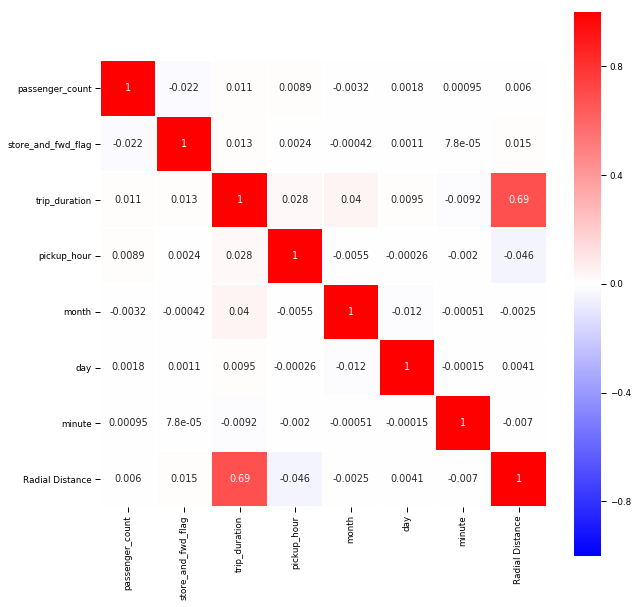

In [254]:
plt.figure(figsize=(10,10))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
sns.set_context("paper", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(store_and_fwd_flag=df_LC.store_and_fwd_flag.astype('category').cat.codes,
                        month=df_LC.month.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


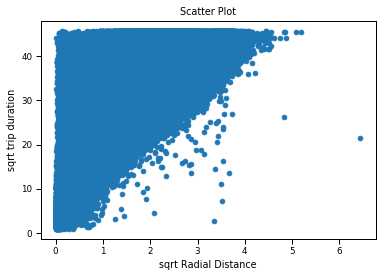

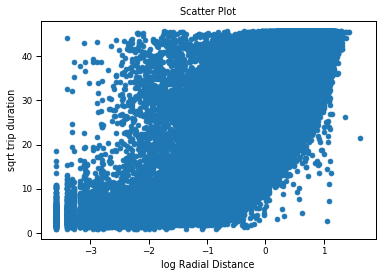

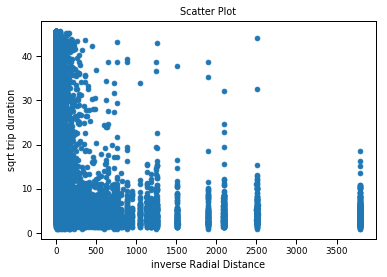

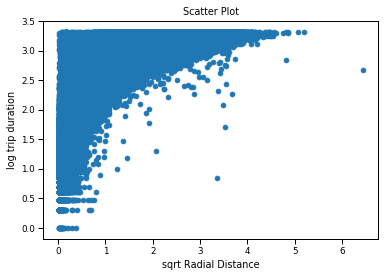

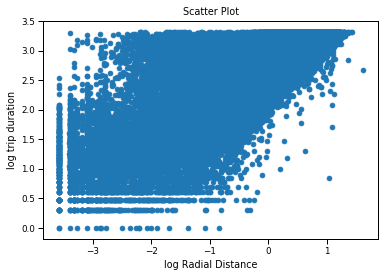

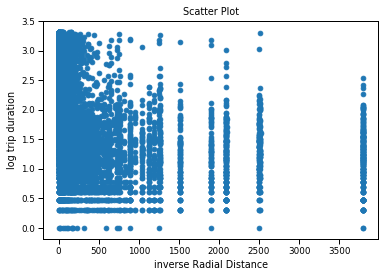

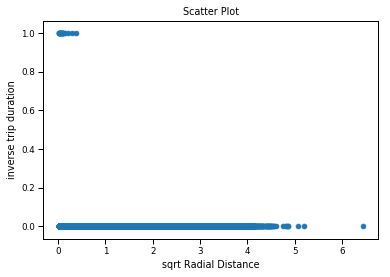

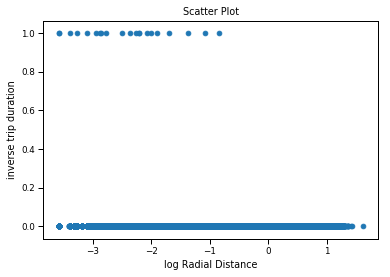

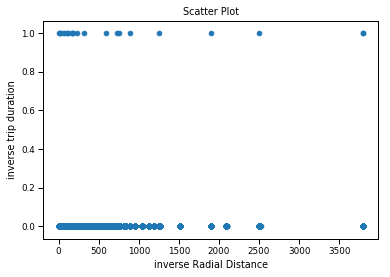

In [255]:
m=[np.sqrt,np.log10,np.reciprocal]
k = ['sqrt','log','inverse']
count=0
def scatterplot():
    global count
    for i in range(0,len(m)):
        y = df_main[['trip_duration']]
        y[['trip_duration']] = m[i](y[['trip_duration']])
        for j in range(0,len(m)):
            x = df_main[['Radial Distance']].astype('float')
            x[['Radial Distance']] = m[j](x[['Radial Distance']])
            plt.scatter(x,y)
            count+=1
            plt.xlabel(k[j] +' Radial Distance')
            plt.ylabel(k[i] +' trip duration')
            plt.title('Scatter Plot')
            plt.pause(0.005)

scatterplot()

['Radial Distance', 'trip_duration']
0    0.930555
Name: Radial Distance, dtype: float64


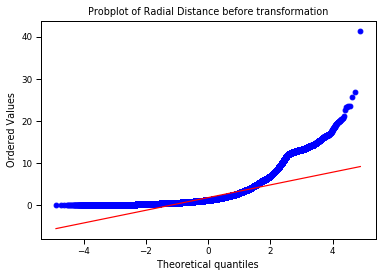

lambda value:  0.14391614184869142


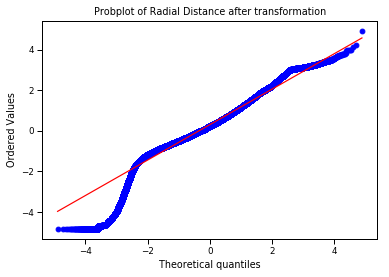

0    455
Name: trip_duration, dtype: int64


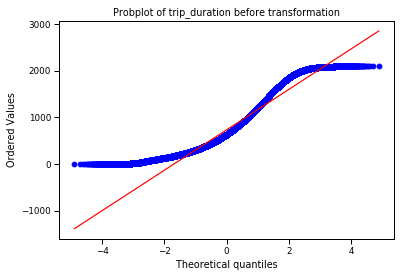

lambda value:  0.34648584762573686


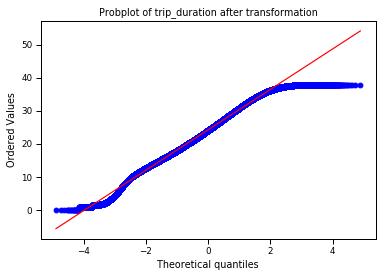

In [256]:
y = df_main

numerical = ['Radial Distance', 'trip_duration']
print(numerical)
lambd = []
for i in numerical:
    print(y[i].head(1))
    stats.probplot(y[i], dist="norm", plot=pylab)
    pylab.title("Probplot of "+i+" before transformation")
    pylab.show()
    yt,_ = stats.boxcox(y[i]) ##lambda=None gives lambda that maximizes the log-likelihood function
    df_main[i] = yt
    lambd.append(_)
    print("lambda value: ", _)
    stats.probplot(y[i], dist="norm", plot=pylab)
    pylab.title("Probplot of "+i+" after transformation")
    pylab.show()

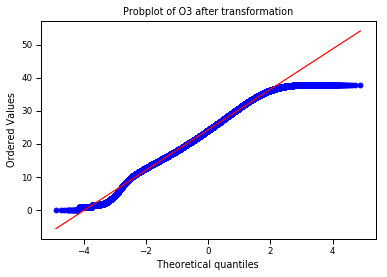

In [257]:
stats.probplot(df_main['trip_duration'], dist="norm", plot=pylab)
pylab.title("Probplot of O3 after transformation")
pylab.show()

In [258]:
#from scipy.stats import boxcox
#numerical = df_main.columns[df_main.dtypes == 'float64']
#for i in numerical:
#    if df_main[i].min() > 0:
#        transformed, lamb = boxcox(df_main.loc[df_main[i].notnull(), i])
#        if np.abs(1 - lamb) > 0.02:
#            df_main.loc[df_main[i].notnull(), i] = transformed

In [259]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
y = df_main['trip_duration']
x = df_main.drop(['vendor_id','id','trip_duration','pickup_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_datetime','dropoff_longitude', 'dropoff_latitude'],axis=1)
#numerical = x.columns[(x.dtypes == 'float64') | (x.dtypes == 'int64')].tolist()
#x[numerical] = sc.fit_transform(x[numerical])

In [260]:

x.columns


Index(['passenger_count', 'store_and_fwd_flag', 'pickup_hour', 'day_week',
       'month', 'day', 'minute', 'Radial Distance'],
      dtype='object')

In [261]:
df_main.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'day_week', 'month', 'day', 'minute',
       'Radial Distance'],
      dtype='object')

In [262]:
x.dtypes

passenger_count         int64
store_and_fwd_flag     object
pickup_hour             int64
day_week               object
month                   int64
day                     int64
minute                  int64
Radial Distance       float64
dtype: object

In [263]:
x = pd.get_dummies(x,drop_first=True)
x = sm.add_constant(x)
model = sm.OLS(y,x)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 1.593e+05
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        08:11:14   Log-Likelihood:            -3.8238e+06
No. Observations:             1378479   AIC:                         7.648e+06
Df Residuals:                 1378465   BIC:                         7.648e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.8698      0.016   1385.018      0.000      21.839      21.901
passenger_count          0.0380      0.003     15.092      0.000       0.033       0.043
pickup_hour              0.0451      0.001     87.739      0.000       0.044       0.046
month                    0.1233      0.002     62.676      0.000       0.119       0.127
day                      0.0038      0.000     10.071      0.000       0.003       0.005
minute                  -0.0012      0.000     -6.384      0.000      -0.002      -0.001
Radial Distance          5.3430      0.004   1431.070      0.000       5.336       5.350
store_and_fwd_flag_Y     0.2440      0.046      5.248      0.000       0.153       0.335
day_week_Monday         -0.8024      0.013    -64.163      0.000      -0.827      -0.778
day_week_Saturday       -0.7264      0.012    -60.829      0.000      -0.750      -0.703
day_week_Sunday         -1.5112      0.012   -122.240      0.000      -1.535      -1.487
day_week_Thursday        0.1993      0.012     16.517      0.000       0.176       0.223
day_week_Tuesday        -0.0255      0.012     -2.083      0.037      -0.050      -0.002
day_week_Wednesday       0.1456      0.012     11.968      0.000       0.122       0.169
==============================================================================
Omnibus:                   120426.874   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234548.898
Skew:                           0.596   Prob(JB):                         0.00
Kurtosis:                       4.632   Cond. No.                         554.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

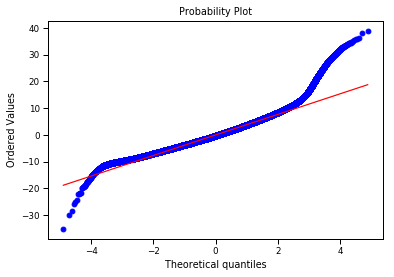

In [264]:
import scipy.stats as stats
import pylab
stats.probplot(res.resid, dist="norm", plot=pylab)
pylab.show()

In [265]:
x['Radial Distance'].describe()

count    1.378479e+06
mean     3.023774e-01
std      8.859085e-01
min     -4.826417e+00
25%     -2.828144e-01
50%      2.204443e-01
75%      8.200419e-01
max      4.925286e+00
Name: Radial Distance, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

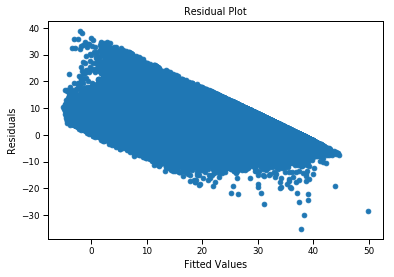

In [266]:
plt.scatter(res.fittedvalues,res.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show

In [267]:
df_model = df_main.drop(['vendor_id','id','pickup_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_datetime','dropoff_longitude', 'dropoff_latitude'], axis=1)

In [268]:
df_model = pd.get_dummies(df_model,drop_first=True)

In [269]:

traindata, testdata = train_test_split(df_model,test_size=.3, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

x_train = traindata.drop(['trip_duration'], axis=1)
y_train = traindata['trip_duration']
x_test = testdata.drop(['trip_duration'], axis=1)
y_test = testdata['trip_duration']


main_model = RandomForestRegressor()
# main_model= xgb.XGBRegressor(iterations=10000, 
#                                 learning_rate=0.01, 
#                                 depth=5, 
#                                 colsample_bylevel=0.7,
#                                 bagging_temperature = 0.2,
#                                 metric_period = None,
#                                 early_stopping_rounds=200)             
main_model.fit(x_train,y_train)


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [270]:
main_model.score(x_test,y_test)

0.6300158867085878

Text(0, 0.5, 'Relative Importance')

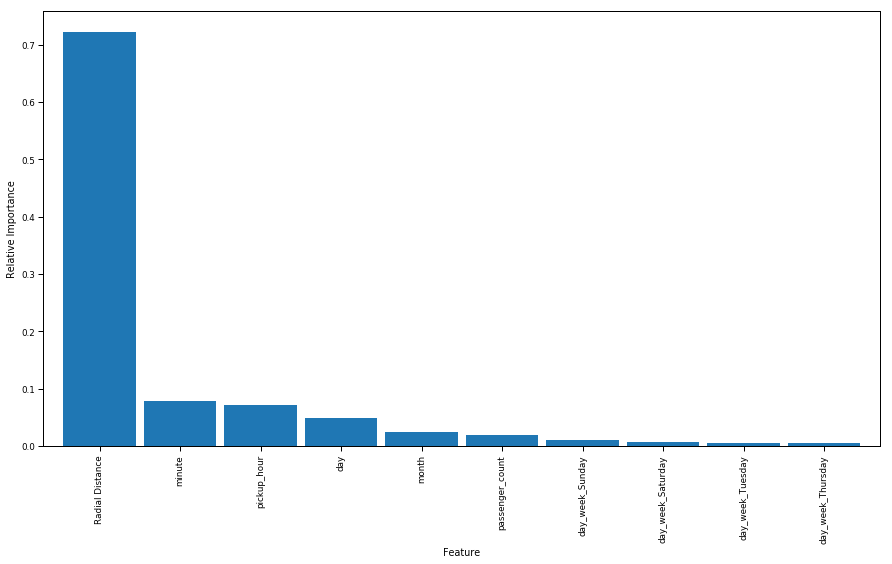

In [271]:
r = pd.DataFrame(columns=['Feature','Importance'])
ncomp = 10
r['Feature'] = feat_labels = x_train.columns
r['Importance'] = main_model.feature_importances_
r.set_index(r['Feature'], inplace=True)
ax = r.sort_values('Importance', ascending=False)[:ncomp].plot.bar(width=0.9, legend=False, figsize=(15,8))
ax.set_ylabel('Relative Importance')

In [272]:
df_main = pd.read_csv("../input/test.csv", low_memory=False)

In [273]:
df_main['pickup_datetime'] = pd.to_datetime(df_main['pickup_datetime'])
df_main['pickup_hour'] = df_main['pickup_datetime'].dt.hour
#df_main['pickup_hour'] = df_main['pickup_hour'].astype('str')
#df_NY['pickup_month'] = df_NY.pickup_datetime.dt.month_name
df_main['day_week'] = df_main['pickup_datetime'].dt.weekday_name
#df_main['day_week'] = df_main['day_week'].astype('str')
df_main['month'] = df_main['pickup_datetime'].dt.month
#df_main['month'] = df_main['month'].astype('str')
df_main['day'] = df_main['pickup_datetime'].dt.day
#df_main['day'] = df_main['day'].astype('str')
#df_main['hour'] = df_main['hour'].astype('str')
df_main['minute'] = df_main['pickup_datetime'].dt.minute
#df_main['minute'] = df_main['minute'].astype('str')
from math import sin, cos, sqrt, atan2, radians
R = 6373.0
df_main.pickup_longitude, df_main.pickup_latitude, df_main.dropoff_longitude, df_main.dropoff_latitude = map(np.radians, [df_main.pickup_longitude, df_main.pickup_latitude, df_main.dropoff_longitude, df_main.dropoff_latitude])  
dlon = df_main.dropoff_longitude - df_main.pickup_longitude
dlat = df_main.dropoff_latitude-df_main.pickup_latitude
expr = np.sin(dlat/2.0)**2 + np.cos(df_main.pickup_latitude) * np.cos(df_main.dropoff_latitude) * np.sin(dlon/2.0)**2
d = 2* np.arcsin(np.sqrt(expr))
df_main['Radial Distance'] = 6367 * d/1.60934

In [274]:
df_main.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,day_week,month,day,minute,Radial Distance
0,id3004672,1,2016-06-30 23:59:58,1,-1.291336,0.710908,-1.291372,0.711338,N,23,Thursday,6,30,59,1.705483
1,id3505355,1,2016-06-30 23:59:53,1,-1.290919,0.710000,-1.290842,0.709571,N,23,Thursday,6,30,59,1.713439
2,id1217141,1,2016-06-30 23:59:47,1,-1.291499,0.711005,-1.291302,0.710864,N,23,Thursday,6,30,59,0.811100
3,id2150126,2,2016-06-30 23:59:41,1,-1.290777,0.711604,-1.291307,0.710881,N,23,Thursday,6,30,59,3.272012
4,id1598245,1,2016-06-30 23:59:33,1,-1.291024,0.711422,-1.290872,0.711324,N,23,Thursday,6,30,59,0.596666


In [275]:
df_model = df_main.drop(['vendor_id','id','pickup_datetime','dropoff_longitude', 'dropoff_latitude','pickup_longitude', 'pickup_latitude'], axis=1)
df_model = pd.get_dummies(df_model,drop_first=True)

In [276]:
df_model.columns

Index(['passenger_count', 'pickup_hour', 'month', 'day', 'minute',
       'Radial Distance', 'store_and_fwd_flag_Y', 'day_week_Monday',
       'day_week_Saturday', 'day_week_Sunday', 'day_week_Thursday',
       'day_week_Tuesday', 'day_week_Wednesday'],
      dtype='object')

In [277]:
df_main[(df_main['Radial Distance']<=0)]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,day_week,month,day,minute,Radial Distance
127,id2195452,1,2016-06-30 23:22:00,1,-1.290845,0.711584,-1.290845,0.711584,N,23,Thursday,6,30,22,0.0
534,id3739596,2,2016-06-30 21:25:57,3,-1.291549,0.710715,-1.291549,0.710715,N,21,Thursday,6,30,25,0.0
694,id3612600,1,2016-06-30 20:35:37,1,-1.290616,0.711136,-1.290616,0.711136,N,20,Thursday,6,30,35,0.0
807,id1014079,2,2016-06-30 19:59:40,1,-1.290844,0.711353,-1.290844,0.711353,N,19,Thursday,6,30,59,0.0
1154,id3326109,1,2016-06-30 18:12:38,1,-1.289212,0.711569,-1.289212,0.711569,N,18,Thursday,6,30,12,0.0
1193,id0680517,2,2016-06-30 17:58:52,1,-1.291238,0.710967,-1.291238,0.710967,N,17,Thursday,6,30,58,0.0
1235,id3393591,2,2016-06-30 17:44:42,5,-1.292434,0.708682,-1.292434,0.708682,N,17,Thursday,6,30,44,0.0
1317,id0801799,2,2016-06-30 17:14:08,1,-1.291062,0.709047,-1.291062,0.709047,N,17,Thursday,6,30,14,0.0
1376,id2510088,1,2016-06-30 16:50:04,1,-1.287940,0.709595,-1.287940,0.709595,N,16,Thursday,6,30,50,0.0
1711,id3119873,1,2016-06-30 14:37:45,1,-1.291272,0.711276,-1.291272,0.711276,N,14,Thursday,6,30,37,0.0


lambda value:  0.14391614184869142


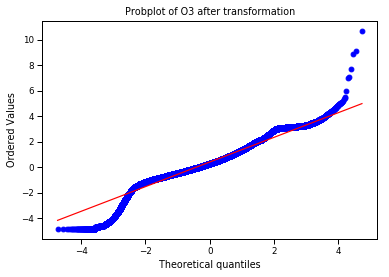

In [278]:
def box(x):
    if x>0:    
        yt = stats.boxcox(x,lmbda = lambd[0] ) ##lambda=None gives lambda that maximizes the log-likelihood function
        return yt
    else:
        return 0

df_model['Radial Distance'] = df_model['Radial Distance'].apply(lambda x: box(x))

print("lambda value: ",lambd[0] )

stats.probplot(df_model['Radial Distance'], dist="norm", plot=pylab)
pylab.title("Probplot of O3 after transformation")
pylab.show()

In [279]:

print(k)

['sqrt', 'log', 'inverse']


In [280]:
#numerical = df_model.columns[(df_model.dtypes == 'float64') | (df_model.dtypes == 'int64')].tolist()
#df_model[numerical] = sc.fit_transform(df_model[numerical])


In [281]:
predictions = main_model.predict(df_model)

In [282]:
from scipy.special import inv_boxcox
k = inv_boxcox(predictions, lambd[1])
print(lambd[1])
predictions = k

0.34648584762573686


In [283]:
df_main['trip_duration'] = predictions
df_main.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,day_week,month,day,minute,Radial Distance,trip_duration
0,id3004672,1,2016-06-30 23:59:58,1,-1.291336,0.710908,-1.291372,0.711338,N,23,Thursday,6,30,59,1.705483,766.451047
1,id3505355,1,2016-06-30 23:59:53,1,-1.290919,0.710000,-1.290842,0.709571,N,23,Thursday,6,30,59,1.713439,766.451047
2,id1217141,1,2016-06-30 23:59:47,1,-1.291499,0.711005,-1.291302,0.710864,N,23,Thursday,6,30,59,0.811100,517.703374
3,id2150126,2,2016-06-30 23:59:41,1,-1.290777,0.711604,-1.291307,0.710881,N,23,Thursday,6,30,59,3.272012,912.906603
4,id1598245,1,2016-06-30 23:59:33,1,-1.291024,0.711422,-1.290872,0.711324,N,23,Thursday,6,30,59,0.596666,452.940460


In [284]:
df_submission = df_main[['id','trip_duration']]
df_submission.head(5)

,id,trip_duration
0,id3004672,766.451047
1,id3505355,766.451047
2,id1217141,517.703374
3,id2150126,912.906603
4,id1598245,452.940460


In [285]:
df_submission.head(5)

,id,trip_duration
0,id3004672,766.451047
1,id3505355,766.451047
2,id1217141,517.703374
3,id2150126,912.906603
4,id1598245,452.940460


In [286]:
df_submission.to_csv('submission.csv', index=False)